In [210]:
# read csv and check the data 
import torch
from torch import nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from torch.nn import functional as F
from d2l import torch as d2l

In [211]:
# data washing
file_name = r"./housing.csv"
data = pd.read_csv(file_name)
# data.drop_duplicates(["ocean_proximity"])  observe the data set 

split_rate = 0.8 # the split partial of training set and testing set
train_path = "train_housing.csv" 
test_path = "test_housing.csv" 

In [212]:
# check is there any NA value
data.isna().sum()

def str2number(str):
    """convert the string value of ocean_proximity to number and train"""
    if str == "ISLAND":
        return 0
    elif str == "NEAR OCEAN":
        return 1
    elif str == "NEAR BAY":
        return 2
    elif str == "<1H OCEAN":
        return 3
    else:
        return 4

data["ocean_proximity"] = data["ocean_proximity"].map(str2number)
data["total_bedrooms"].interpolate("linear", inplace=True)

def load_data(file_name):
    data = pd.read_csv(file_name)
    data["ocean_proximity"] = data["ocean_proximity"].map(str2number)
    data["total_bedrooms"].interpolate("linear", inplace=True)
    return data


data.columns[0]
data.loc[:, "ocean_proximity"]

def save_data(data, file_name):
    data.to_csv(file_name, index=False)

def split_data(data, split_rate, path):
    "split the original dataframe and save to train_file_name file"
    tmp = int(len(data) * split_rate)
    train_data = data[0:tmp]
    test_data = data[tmp:]
    train_path, test_path = path
    save_data(train_data, train_path)
    save_data(test_data, test_path)

split_data(data, split_rate, (train_path, test_path))

In [213]:
class housedataset(Dataset):
    def __init__(self, filename):
        self.data = load_data(filename)
        self.column_length = len(self.data.columns)
        self.data_features = self.data.iloc[:,[x for x in range(self.column_length) if self.data.columns[x] != "median_house_value"]]
        self.targets = self.data.loc[:, "median_house_value"]
    
    def __getitem__(self, index):
        # how to extract the data and labels from the whole data

        data_features, targets = self.data_features.iloc[index], self.targets.iloc[index] # index first

        # print(data_features.values.shape)

        targets = targets if type(targets) != pd.Series else targets.values

        data = torch.tensor(data_features.values, dtype=torch.float32) # convert dataframe into tensor
        targets = torch.tensor(targets, dtype=torch.float32)

        return data, targets


    def __len__(self):
        return len(self.data)

In [214]:
# set hyper parameters
epochs = 100
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
lr = 0.1
batch_size = 256


In [215]:
# Load the data

# dataset = housedataset(filename) # use our own value to make dataset

train_set = housedataset(train_path)
test_set = housedataset(test_path)

# this operation is really wrong !!!!! The train_set is not dataset
# train_set = dataset[0:int(split_rate * len(dataset))]
# test_set = dataset[int(split_rate * len(dataset)) : ]

# batchsize = 64


train_data = DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
test_data = DataLoader(test_set, batch_size, shuffle=True, drop_last=True)

# test the data loader
for data in train_data:
    values, targets = data
    print(values.shape)
    # print(targets)
    break


torch.Size([256, 9])


In [216]:
len(test_set)

4128

In [217]:
# define loss function to solve the MSELoss's Nan situation
class price_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss_metric = torch.square((x-y)/x)
        return loss_metric.sum() # if x is very big the loss is almost 1?

In [218]:
def xavier_weight_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    

In [219]:
# define neural network
class Housing(nn.Module):
    def __init__(self):
        """consider the dataset is just 17777 numbers
        so the neural network is very simple
        """
        super(Housing, self).__init__()
        self.lin1 = nn.Linear(9, 20) 
        self.lin2 =nn.Linear(20, 5)
        self.lin3 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x)) # add relu layer
        x = self.lin3(x)
        return x



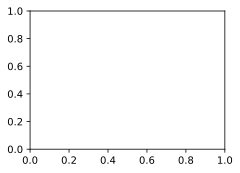

In [220]:
animator = d2l.Animator(xlim=(1, epochs), ylim=(1, limitation), legend=["train_loss", "test_loss"])
metric = d2l.Accumulator(2)

In [221]:
house = Housing()
house.apply(xavier_weight_init)
house.to(device)
# define loss function
# loss_fn = nn.MSELoss().to(device)
loss_fn = price_loss().to(device)

optim = torch.optim.Adam(house.parameters(), lr=lr)
batch_num = len(train_set) // batch_size # how much batch during single epoch 
batch_num / 10
limitation = 5000

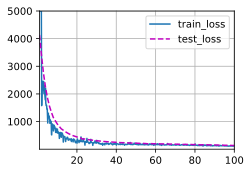

In [222]:
# training the model
for epoch in range(epochs):
    house.train() # start the training model
    metric.reset()
    for i, (values, targets) in enumerate(train_data):
        values, targets = values.to(device), targets.to(device)
        
        optim.zero_grad()
        res = house(values)
        targets = targets.reshape(res.shape)
        train_loss = loss_fn(res, targets)
        train_loss.backward()
        optim.step()
        metric.add(train_loss.cpu(), 1)
        if (i+1) % (batch_num // 10) == 0 or ((i-1)==batch_num):
            avg_loss = metric[0] / metric[1]
            avg_loss = (limitation if avg_loss > limitation else avg_loss)
            animator.add(epoch + 1 + i / batch_num, (avg_loss, None))
            
    house.eval()
    with torch.no_grad():
        total_loss = torch.tensor(0.0, device=device)
        num = 0
        for (values, targets) in test_data:
            values, targets = values.to(device), targets.to(device)
            
            res = house(values)
            targets = targets.reshape(res.shape)
            train_loss = loss_fn(res, targets)

            total_loss += train_loss
            num += 1
        avg_loss  = (limitation if total_loss / num > limitation else total_loss.cpu() / num)
        
        animator.add(epoch + 1, (None, avg_loss))

        

